<a href="https://colab.research.google.com/github/FedericoSabbadini/RetiNeuraliGenerative/blob/main/lezione/Text%20Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Translation with T5

## The Dataset

In [94]:
!wget https://www.manythings.org/anki/ita-eng.zip -P ./data/
!unzip ./data/ita-eng.zip -d ./data/

--2025-11-14 11:12:34--  https://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8846174 (8.4M) [application/zip]
Saving to: ‘./data/ita-eng.zip.4’

ita-eng.zip.4       100%[===================>]   8.44M  45.0MB/s    in 0.2s    

2025-11-14 11:12:35 (45.0 MB/s) - ‘./data/ita-eng.zip.4’ saved [8846174/8846174]

Archive:  ./data/ita-eng.zip
replace ./data/ita.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [95]:
import os
import torch
import random
import numpy as np

SEED = 124564

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

torch.cuda.empty_cache()
torch.cuda.synchronize()
set_seed(SEED)

In [96]:
import pandas as pd

df = pd.read_csv("./data/ita.txt", sep="\t", header=None, names=["english", "italian", "attrib"])
df.drop(["attrib"], axis=1, inplace=True)

df = df.drop_duplicates().dropna().reset_index(drop=True)

df

,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!
...,...,...
400008,I know that adding sentences only in your nati...,So che aggiungere frasi soltanto nella sua lin...
400009,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
400010,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
400011,Doubtless there exists in this world precisely...,Senza dubbio esiste in questo mondo proprio la...


MIN: 2
MEAN: 10.884771244934539
MAX: 193

QUANTILE
0.01     4.0
0.25     8.0
0.50    10.0
0.75    13.0
0.99    23.0
dtype: float64


<Axes: >

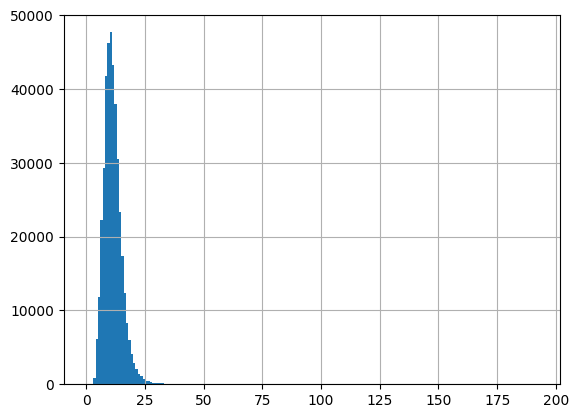

In [97]:
# Number of words distribution.

lens_eng = df.english.str.split().map(lambda x: len(x))
lens_it = df.italian.str.split().map(lambda x: len(x))

lens = lens_eng + lens_it

print(f"MIN: {lens.min()}")
print(f"MEAN: {lens.mean()}")
print(f"MAX: {lens.max()}")


print("\nQUANTILE")
print(lens.quantile([0.01, 0.25, 0.5, 0.75, 0.99]))

lens.hist(bins = np.arange(0, max(lens), 1))

In [104]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer


class TranslationDataset(Dataset):

  def __init__(self, df, model, in_lang, out_lang, task_prefix, max_in_len, max_out_len):
    super(TranslationDataset, self).__init__()
    self.df = df
    self.tokenizer = AutoTokenizer.from_pretrained(model)
    self.in_lang = in_lang
    self.out_lang = out_lang
    self.max_in_len = max_in_len
    self.max_out_len = max_out_len
    self.task_prefix = task_prefix

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    in_encoded = self.tokenizer(self.df.loc[idx, self.in_lang], padding="max_length", truncation=True, max_length=self.max_in_len, return_tensors="pt")
    in_tokens = in_encoded['input_ids'].squeeze(0)
    in_mask = in_encoded['attention_mask'].squeeze(0)

    out_encoded = self.tokenizer(self.df.loc[idx, self.out_lang], padding="max_length", truncation=True, max_length=self.max_out_len, return_tensors="pt")
    out_tokens = out_encoded['input_ids'].squeeze(0)
    out_tokens[out_tokens == self.tokenizer.pad_token_id] = -100 # 456,23653,136,0,0 -> 456,23653,136,-100,-100

    return in_tokens, in_mask, out_tokens

In [99]:
df_train = df.sample(frac=0.8, random_state=SEED).reset_index(drop=True)

df_test = df.drop(df_train.index).reset_index(drop=True)
df_val = df_test.sample(frac=0.5, random_state=SEED).reset_index(drop=True)

df_test = df_test.drop(df_val.index).reset_index(drop=True)


print(f"#Train examples: {len(df_train)}")
print(f"#Val   examples: {len(df_test)}")
print(f"#Test  examples: {len(df_val)}")

#Train examples: 320010
#Val   examples: 40001
#Test  examples: 40002


*Documentation:*

 - [HuggingFace T5](https://huggingface.co/docs/transformers/model_doc/t5)
 - [t5-small](https://huggingface.co/t5-small)

In [100]:
from torch.utils.data import DataLoader

T5 = "t5-small"
MAX_SOURCE_LEN = 32
MAX_TARGET_LEN = 32
BATCH_SIZE = 256
ACCUMULATION = 2

in_lange = "english"
out_lang = "italian"
prefix = "Translate English to Italian: "

train_dataset = TranslationDataset(df_train, T5, in_lange, out_lang, prefix, MAX_SOURCE_LEN, MAX_TARGET_LEN)
val_dataset = TranslationDataset(df_val, T5, in_lange, out_lang, prefix, MAX_SOURCE_LEN, MAX_TARGET_LEN)
test_dataset = TranslationDataset(df_test, T5, in_lange, out_lang, prefix, MAX_SOURCE_LEN, MAX_TARGET_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### T5ForConditionalGeneration <br>


*Documentation:* <br>

 - [torch.nn](https://pytorch.org/docs/stable/nn.html)

a differenza di BERT, T5 non prevede il pooler

In [105]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score
from transformers import T5ForConditionalGeneration
from torch import nn
from tqdm import tqdm
import copy


class Translator(nn.Module):

    def __init__(self, transformer, model_name, device):
        super(Translator, self).__init__()
        self.model_name = model_name
        self.device = device
        self.llm_layer = T5ForConditionalGeneration.from_pretrained(transformer)

    def forward(self, input_ids, attn_mask, labels):
        output = self.llm_layer(
        input_ids, attn_mask, labels=labels)
        return output.logits, output.loss

    def train_architecture(self, train_data, val_data, epochs, accumulation, optimizer, scaler):

        train_losses = []
        val_losses = []
        accuracies = []
        best_valloss = np.inf
        best_ep = 0
        best_model = copy.deepcopy(self.state_dict())

        for ep in range(epochs):
            self.train()
            optimizer.zero_grad()

            ep_loss = 0.0

            for i, batch in enumerate(tqdm(train_data)):

                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits, loss = self(input_ids, attn_masks, labels)

                scaler.scale(loss).backward()

                ep_loss += loss.item()

                # Backpropagation
                if (i + 1) % accumulation == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

            train_losses.append(ep_loss/len(train_data))

            # Evaluation

            val_loss, accuracy = self.eval_model(val_data)
            accuracies.append(accuracy)
            val_losses.append(val_loss)

            if val_loss < best_valloss:
                best_valloss = val_loss
                best_model = copy.deepcopy(self.state_dict())
                best_ep = ep+1

        torch.save(best_model, f"models/{self.model_name}.pth")

        return train_losses, accuracies, val_losses, best_ep, best_valloss


    def eval_model(self, val_data):
        self.eval()

        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_data:
                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits, loss = self(input_ids, attn_masks, labels)
                    val_loss += loss.item()

                    val_preds.extend(logits.argmax(dim=-1).cpu().numpy().flatten().tolist())
                    val_labels.extend(labels.cpu().numpy().flatten().tolist())

        return val_loss/len(val_data), accuracy_score(val_labels, val_preds)


    def predict_data(self, test_data):
        self.eval()

        test_preds = []
        test_labels = []

        with torch.no_grad():
            for batch in tqdm(test_data, total=len(test_data)):
                input_ids, attn_masks, labels = [b.to(self.device) for b in batch]

                with autocast('cuda'):
                    logits, _ = self(input_ids, attn_masks, labels)

                test_preds += logits.argmax(dim=-1).cpu().numpy().flatten().tolist()
                test_labels += labels.cpu().numpy().flatten().tolist()

        return test_preds, test_labels

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device loaded: {device}")

lr = 2e-4
epochs = 5

Device loaded: cuda


In [106]:
from torch.optim import AdamW
!mkdir -p models

translator = Translator(T5, "translator", device).to(device)
optimizer = AdamW(translator.parameters(), lr=lr)
scaler = GradScaler()


print("Training the model...")
train_losses, accuracies, val_losses, best_ep, best_valloss = translator.train_architecture(train_loader, val_loader, epochs, ACCUMULATION, optimizer, scaler)

print(f"\n\nBest model at epoch {best_ep} with val loss {round(best_valloss, 4)}")

Training the model...


 25%|██▍       | 307/1251 [02:27<07:33,  2.08it/s]


KeyboardInterrupt: 

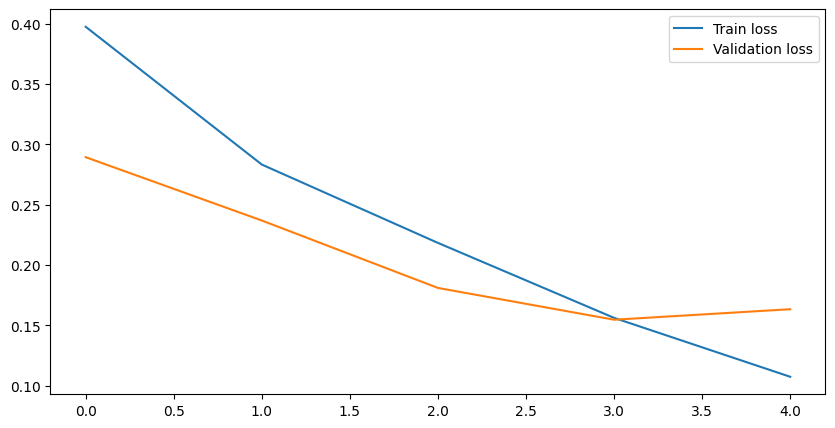

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

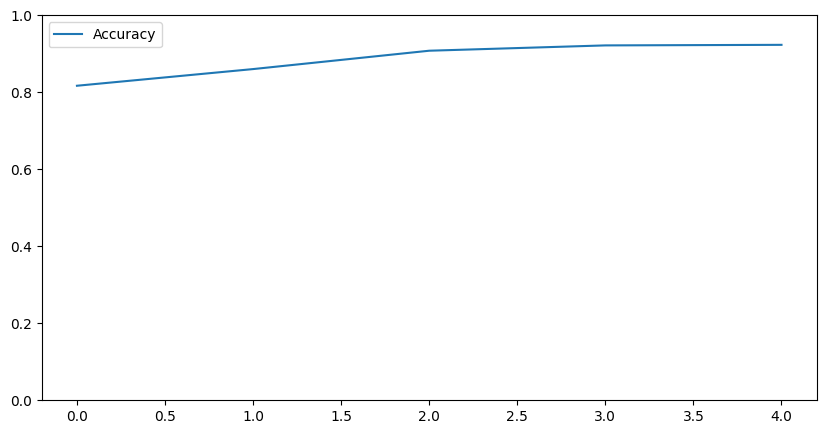

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Testing

BLEU (BiLingual Evaluation Understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is".

**BLEU's output is always a number between 0 and 1.** This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.


*Documentation:*

- [NLTK Implementation](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
- [EXTRA: SmoothingFunction](https://aclanthology.org/W14-3346.pdf)

In [109]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(labels, preds):
    labels = np.reshape(labels, (round(len(test_preds)/MAX_TARGET_LEN), MAX_TARGET_LEN)).tolist()
    preds = np.reshape(preds, (round(len(test_preds)/MAX_TARGET_LEN), MAX_TARGET_LEN)).tolist()

    bleus = []
    for ref, cand in zip(labels, preds):
        bleus.append(sentence_bleu([ref], cand, weights=[0.25, 0.25, 0.25, 0.25], smoothing_function=SmoothingFunction().method7))

    return sum(bleus)/len(bleus)
# fai vedere con e senza pesi
translator.load_state_dict(torch.load(f"models/{translator.model_name}.pth", weights_only=False))
test_preds, test_labels = translator.predict_data(test_loader)

print(f"Test BLEU Score for {translator.model_name} model: {round(compute_bleu(test_labels, test_preds), 2)}")
print(f"Test Accuracy for {translator.model_name} model: {round(accuracy_score(test_labels, test_preds)*100, 2)}%")

FileNotFoundError: [Errno 2] No such file or directory: 'models/translator.pth'